In [44]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import scipy
from statsmodels.stats.weightstats import *

In [45]:
df = pd.read_excel('Ювелирный магазин, данные.xlsx')
df.head(3)

,date,Variant,cnt(addToCart),sum(addToCartItems)
0,2019-09-01,90,56,110247
1,2019-09-01,10,52,163098
2,2019-09-02,10,59,93317


In [46]:
df.dtypes

date                   datetime64[ns]
Variant                         int64
cnt(addToCart)                  int64
sum(addToCartItems)             int64
dtype: object

In [47]:
df.shape

(50, 4)

In [48]:
df.groupby('Variant')['sum(addToCartItems)'].describe()

,count,mean,std,min,25%,50%,75%,max
Variant,,,,,,,,
10,25.0,38352.88,33448.994095,7048.0,18025.0,32306.0,42514.0,163098.0
90,25.0,40602.12,57678.076016,5191.0,16466.0,22530.0,32116.0,286956.0


In [49]:
# Среднее количество человек за сутки

df.groupby('Variant')['cnt(addToCart)'].describe()

# В обоих случаях в среднем 47 человек за сутки

,count,mean,std,min,25%,50%,75%,max
Variant,,,,,,,,
10,25.0,47.8,26.843683,12.0,39.0,44.0,52.0,156.0
90,25.0,47.2,17.036725,20.0,36.0,46.0,56.0,90.0


In [50]:
total_customers = df['cnt(addToCart)'].sum()
total_sum = df['sum(addToCartItems)'].sum()
print('total_customers = {}, total_sum = {}'.format(total_customers, total_sum))

total_customers = 2375, total_sum = 1973875


In [51]:
#Ожидаемый прирост прибыли %

mean_10, mean_90 = df.groupby(['Variant']).agg({'sum(addToCartItems)' : 'mean'}).values
print(int(mean_90 / mean_10 * 100) - 100, '%')

5 %


In [52]:
#Ожидаемый прирост прибыли %

mean_10, mean_90 = df.groupby(['Variant']).agg({'sum(addToCartItems)' : 'median'}).values
print(int(mean_10 / mean_90 * 100) - 100, '%')

43 %


In [53]:
# Среднее количество человек за сутки
n_mean = df.groupby('date')['cnt(addToCart)'].sum().mean()
n_mean

95.0

In [54]:
# Для 5% среднего показателя роста и 3% ожидаемого абсолютного прироста потребуется выборка из 1657 человек

1657/n_mean     # делим на среднее количество человек в сутки, получаем 17,5 дней

17.442105263157895

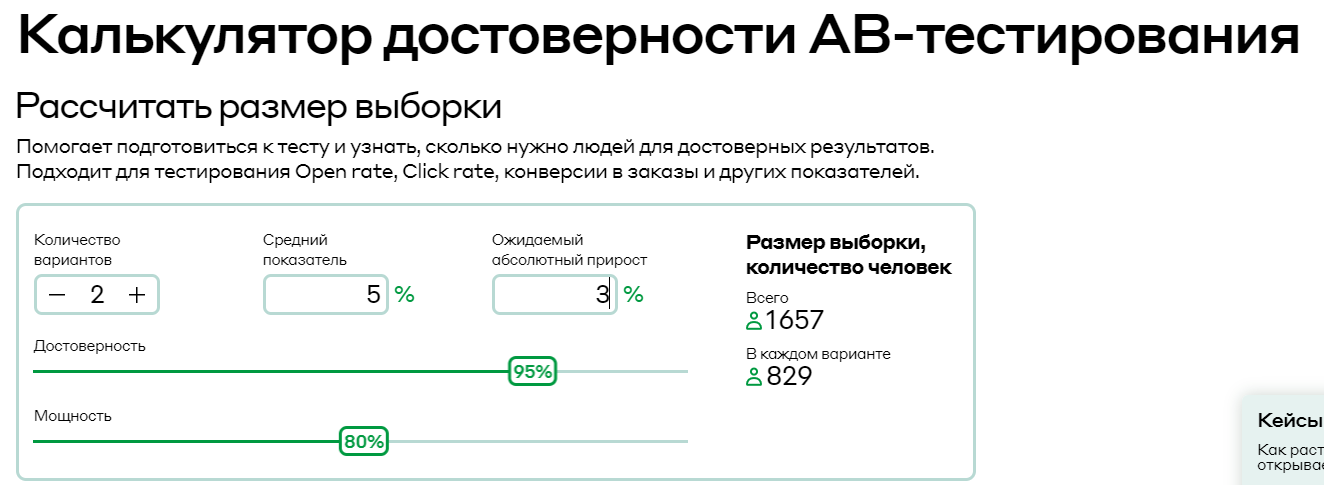

# Конверсия и p-value

In [55]:
df['price'] = df['sum(addToCartItems)'] / df['cnt(addToCart)']
df.loc[df['Variant'] == 10, 'Variant'] = 'Calc'
df.loc[df['Variant'] == 90, 'Variant'] = 'Table'
df.head()

,date,Variant,cnt(addToCart),sum(addToCartItems),price
0,2019-09-01,Table,56,110247,1968.696429
1,2019-09-01,Calc,52,163098,3136.500000
2,2019-09-02,Calc,59,93317,1581.644068
3,2019-09-02,Table,56,26457,472.446429
4,2019-09-03,Table,54,56418,1044.777778


In [56]:
df.groupby(['Variant']).agg({'price':'mean'})

,price
Variant,
Calc,814.605073
Table,729.021425


In [57]:
df.groupby('Variant').price.describe()

,count,mean,std,min,25%,50%,75%,max
Variant,,,,,,,,
Calc,25.0,814.605073,585.519125,227.282051,508.125000,677.217391,906.000000,3136.500000
Table,25.0,729.021425,714.678840,238.066667,382.652174,480.181818,729.909091,3678.923077


In [58]:
price = df.groupby(['Variant','date']).agg({'price':'sum'})

In [59]:
import pylab
import matplotlib.dates as mdates

Text(0, 0.5, 'Разница Calc-Table')

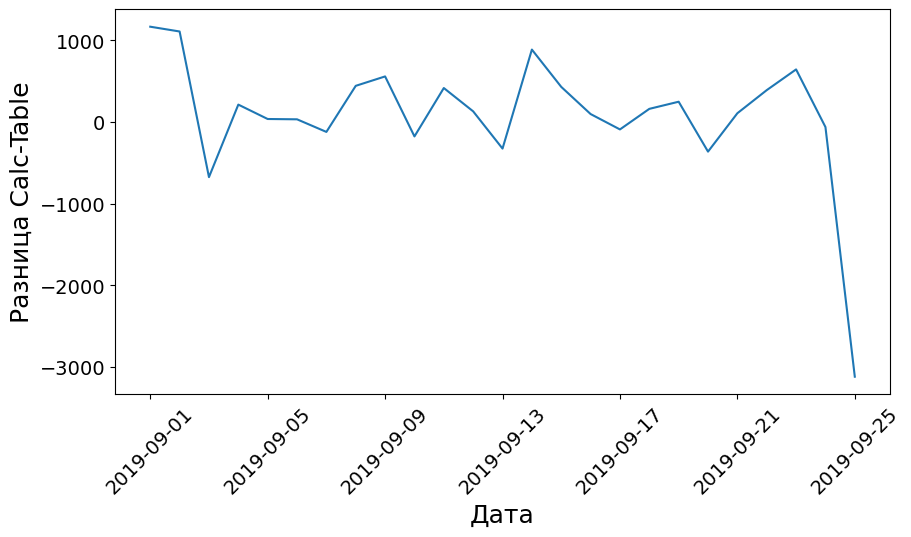

In [60]:
diff = pd.DataFrame(price.price.loc['Calc'] - price.price.loc['Table'])

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(diff)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Дата",fontsize=18)
plt.ylabel("Разница Calc-Table",fontsize=18)

# diff.plot(kind='line',alpha=0.75, rot=0)
# plt.xlabel("")
# plt.show()

In [61]:
def bootstrap(arr,n=100,N_TRIAL = 1000,func = np.mean):
    res = []
    n = min(len(arr),n)
    # Инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # Делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size = (n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size = (n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res # shape (N_TRIAL,)

# Проверка значимости различий


In [62]:
samples_a = bootstrap(df.query("Variant=='Calc'")['price'],N_TRIAL = 3000)
samples_b = bootstrap(df.query("Variant=='Table'")['price'],N_TRIAL = 3000)

C:\Users\persi\AppData\Local\Temp\ipykernel_7824\4010943721.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples_a,label = 'Calc')
C:\Users\persi\AppData\Local\Temp\ipykernel_7824\4010943721.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_b,ax = ax,label = 'Table')


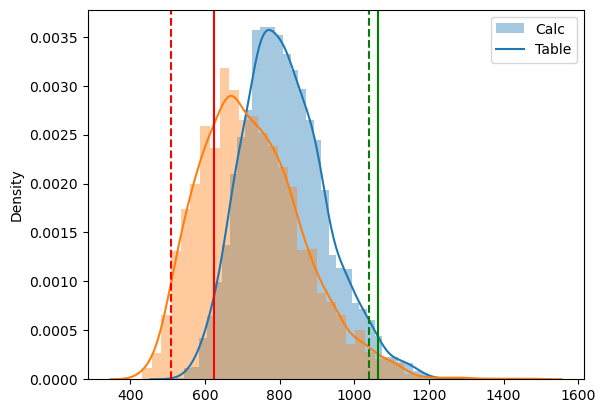

In [63]:
# Визуализируем выборки и доверительные интервалы
import seaborn as sns
ax = sns.distplot(samples_a,label = 'Calc')
sns.distplot(samples_b,ax = ax,label = 'Table')
ax.legend(['Calc','Table'])
ax.axvline(np.percentile(samples_a,2.5),linestyle = '-',color='r')
ax.axvline(np.percentile(samples_a,97.5),linestyle = '-',color='g')

ax.axvline(np.percentile(samples_b,2.5),linestyle = '--',color='r')
ax.axvline(np.percentile(samples_b,97.5),linestyle = '--',color='g')

In [64]:
buf = []
for i in range(1000):
    a_sample =  df.query("Variant=='Calc'")['cnt(addToCart)'].sample(100, replace = True)
    b_sample =  df.query("Variant=='Table'")['cnt(addToCart)'].sample(100, replace = True)
    buf.append(np.mean(b_sample)-np.mean(a_sample))

min = -6.740250000000002 max = 5.040249999999999


C:\Users\persi\AppData\Local\Temp\ipykernel_7824\915952271.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax_buf = sns.distplot(buf)


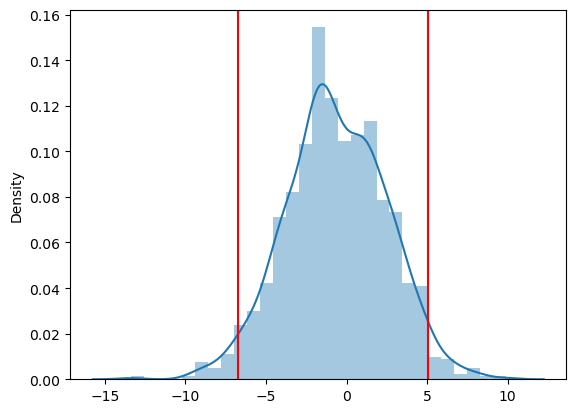

In [65]:
# Визуализируем разницу средних по вариантам

ax_buf = sns.distplot(buf)
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf,2.5),'max =',np.percentile(buf,97.5))

## Сумма добавленных в корзину покупок

C:\Users\persi\AppData\Local\Temp\ipykernel_7824\497567774.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples_a_resp,label = 'Calc')
C:\Users\persi\AppData\Local\Temp\ipykernel_7824\497567774.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_b_resp,ax = ax,label = 'Table'

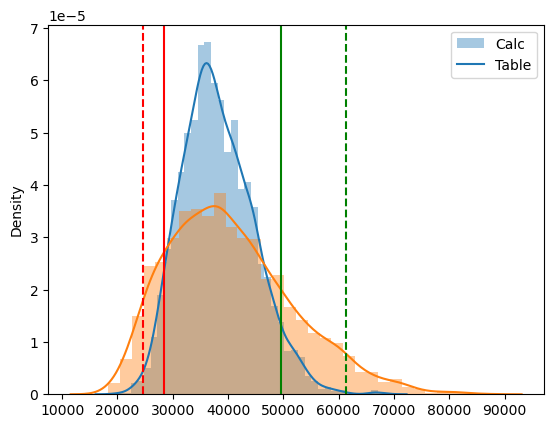

In [66]:
# Визуализируем выборки и доверительные интервалы
samples_a_resp = bootstrap(df.query("Variant=='Calc'")['sum(addToCartItems)'],N_TRIAL = 3000)
samples_b_resp = bootstrap(df.query("Variant=='Table'")['sum(addToCartItems)'],N_TRIAL = 3000)
ax = sns.distplot(samples_a_resp,label = 'Calc')
sns.distplot(samples_b_resp,ax = ax,label = 'Table')
ax.legend(['Calc','Table'])
ax.axvline(np.percentile(samples_a_resp,5),linestyle = '-',color='r')
ax.axvline(np.percentile(samples_a_resp,95),linestyle = '-',color='g')

ax.axvline(np.percentile(samples_b_resp,5),linestyle = '--',color='r')
ax.axvline(np.percentile(samples_b_resp,95),linestyle = '--',color='g')

In [67]:
buf_1=[]
for i in range(1000):
    a_sample =  df.query("Variant=='Calc'")['sum(addToCartItems)'].sample(100, replace = True)
    b_sample =  df.query("Variant=='Table'")['sum(addToCartItems)'].sample(100, replace = True)
    buf_1.append(np.mean(b_sample)-np.mean(a_sample))

min = -9672.781000000003 max = 15780.921750000003


C:\Users\persi\AppData\Local\Temp\ipykernel_7824\437799821.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax_buf = sns.distplot(buf_1)


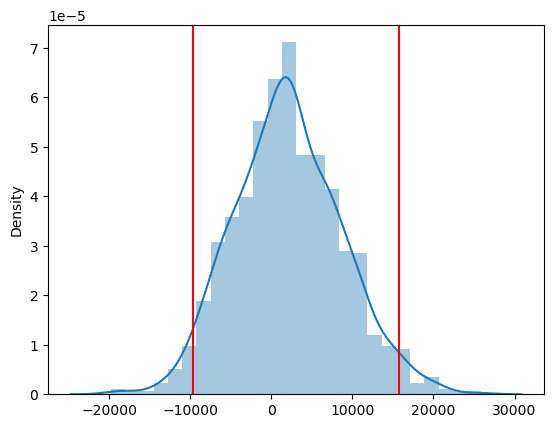

In [68]:
# Визуализируем разницу средних по вариантам
ax_buf = sns.distplot(buf_1)
ax_buf.axvline(np.percentile(buf_1,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf_1,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf_1,2.5),'max =',np.percentile(buf_1,97.5))

На визуализации выборок замтно наложение графиков, поэтому наша нулевая гипотеза о том, что различий нет, верна. Распределение средних близко к нормальному. 

# Проверка различий без выбросов


In [69]:
price.query("date=='2019-09-25'")

,,price
Variant,date,
Calc,2019-09-25,557.636364
Table,2019-09-25,3678.923077


In [70]:
df = df.drop(df.loc[df['date'] == ('2019-09-25')].index)

In [71]:
df['price'] = df['sum(addToCartItems)'] / df['cnt(addToCart)']
df.loc[df['Variant'] == 10, 'Variant'] = 'Calc'
df.loc[df['Variant'] == 90, 'Variant'] = 'Table'
df.head()

,date,Variant,cnt(addToCart),sum(addToCartItems),price
0,2019-09-01,Table,56,110247,1968.696429
1,2019-09-01,Calc,52,163098,3136.500000
2,2019-09-02,Calc,59,93317,1581.644068
3,2019-09-02,Table,56,26457,472.446429
4,2019-09-03,Table,54,56418,1044.777778


In [72]:
price = df.groupby(['Variant','date']).agg({'price':'sum'})

Text(0, 0.5, 'Разница Calc-Table')

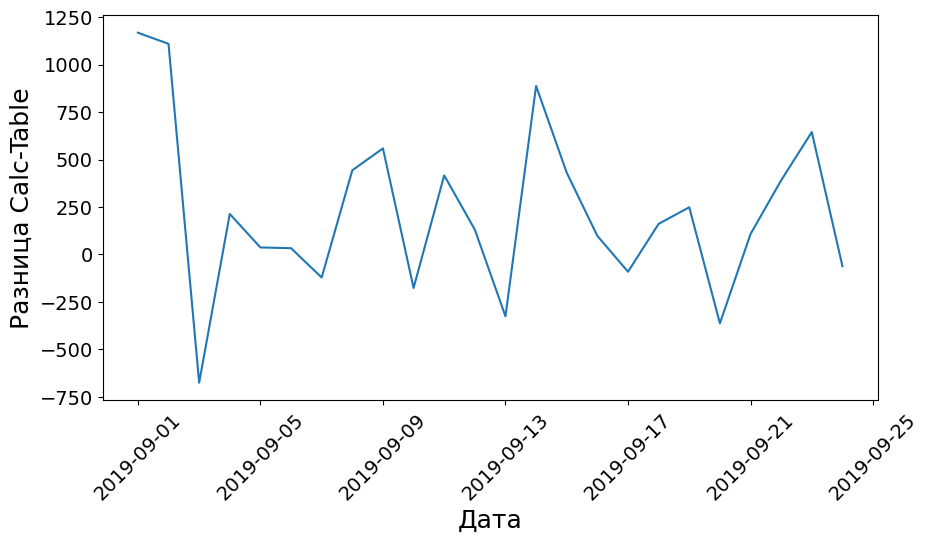

In [73]:
diff = pd.DataFrame(price.price.loc['Calc'] - price.price.loc['Table'])



fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(diff)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Дата",fontsize=18)
plt.ylabel("Разница Calc-Table",fontsize=18)

# diff.plot(kind='line',alpha=0.75, rot=0)
# plt.xlabel("")
# plt.show()

In [74]:
df.groupby('Variant').price.describe()

,count,mean,std,min,25%,50%,75%,max
Variant,,,,,,,,
Calc,24.0,825.312103,595.607078,227.282051,497.657703,679.283696,928.621795,3136.500000
Table,24.0,606.108856,372.645099,238.066667,381.401630,476.314123,670.282828,1968.696429


# Проверка значимости различий

In [79]:
samples_a = bootstrap(df.query("Variant=='Calc'")['price'],N_TRIAL = 3000)
samples_b = bootstrap(df.query("Variant=='Table'")['price'],N_TRIAL = 3000)

C:\Users\persi\AppData\Local\Temp\ipykernel_7824\4010943721.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples_a,label = 'Calc')
C:\Users\persi\AppData\Local\Temp\ipykernel_7824\4010943721.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_b,ax = ax,label = 'Table')


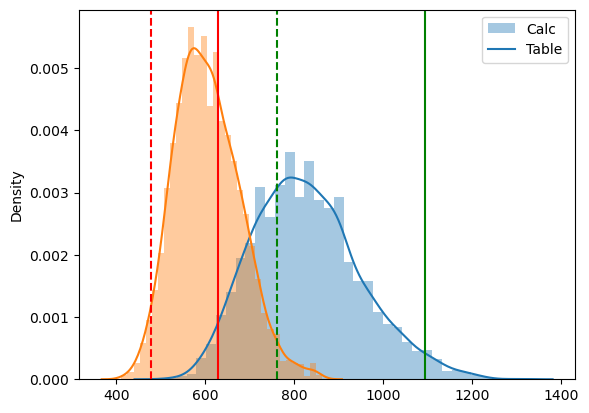

In [80]:
# Визуализируем выборки и доверительные интервалы
import seaborn as sns
ax = sns.distplot(samples_a,label = 'Calc')
sns.distplot(samples_b,ax = ax,label = 'Table')
ax.legend(['Calc','Table'])
ax.axvline(np.percentile(samples_a,2.5),linestyle = '-',color='r')
ax.axvline(np.percentile(samples_a,97.5),linestyle = '-',color='g')

ax.axvline(np.percentile(samples_b,2.5),linestyle = '--',color='r')
ax.axvline(np.percentile(samples_b,97.5),linestyle = '--',color='g')

In [81]:
buf = []
for i in range(1000):
    a_sample =  df.query("Variant=='Calc'")['cnt(addToCart)'].sample(100, replace = True)
    b_sample =  df.query("Variant=='Table'")['cnt(addToCart)'].sample(100, replace = True)
    buf.append(np.mean(b_sample)-np.mean(a_sample))

min = -9.276249999999996 max = 3.010749999999997


C:\Users\persi\AppData\Local\Temp\ipykernel_7824\915952271.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax_buf = sns.distplot(buf)


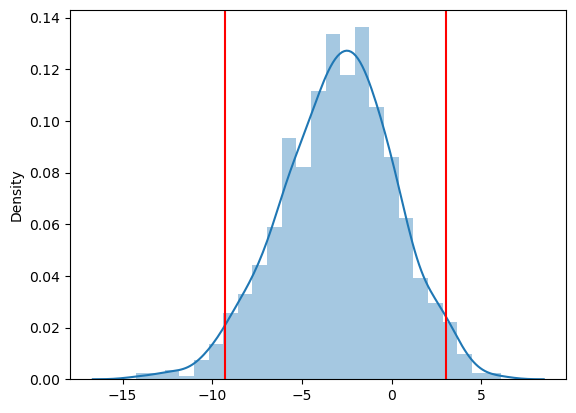

In [83]:
# Визуализируем разницу средних по вариантам

ax_buf = sns.distplot(buf)
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf,2.5),'max =',np.percentile(buf,97.5))

На визуализации выборок графики смещены относительно друг друга, но есть некоторое их пересечение, поэтому однозначно отвергнуть нулевую гипотезу о том, что различий нет, нельзя. Распределение средних близко имеет левостороннее смещение. МОжно сделать вывод о том, что калькулятор будет приносить большую прибыль по сравнению с таблицей.